# Visualizing Irrigation Data

## Cem Onel

### Libraries

In [176]:
import pandas
import numpy
import datetime
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
from pandas.plotting import register_matplotlib_converters
# %matplotlib qt

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

pandas.options.display.max_rows = 999
MIN_MOISTURE = 600

## Data Preparation

In [177]:
## Retrieve Data from Csv File
# irrigation_data = pandas.read_csv('low_sample_data/1.csv',sep='\t', encoding="ISO-8859-1")
irrigation_data = pandas.read_csv('low_sample_data/7.csv',sep=',', encoding="ISO-8859-1")

irrigation_data.dropna(inplace=True)
# Time Preparation
irrigation_data['time'] = irrigation_data['time'].apply(lambda ts: ts)
irrigation_data['time'] = irrigation_data['time'].apply(lambda ts: datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))
irrigation_data.set_index(irrigation_data['time'], inplace=True)

del irrigation_data['time']

# Soil-Mosutire Percantage Calculation
max_soil_moisture = irrigation_data['soil_moisture'].max()
irrigation_data['soil_moisture'] = irrigation_data['soil_moisture'].apply(lambda x: max_soil_moisture - x)
max_soil_moisture = irrigation_data['soil_moisture'].max()
min_soil_moisture = irrigation_data['soil_moisture'].min()

irrigation_data['soil_moisture'] = irrigation_data['soil_moisture'].apply(lambda x: (x/max_soil_moisture)*100)

irrigation_data

,soil_moisture,temperature,air_humidity
time,,,
2020-04-10 14:17:04,36.036036,25.1,57.0
2020-04-10 14:31:04,18.018018,24.2,62.0
2020-04-10 14:45:09,14.414414,24.1,64.0
2020-04-10 14:59:14,14.414414,24.0,65.0
2020-04-10 15:13:23,13.513514,24.1,67.0
2020-04-10 15:27:31,17.117117,24.1,69.0
2020-04-10 15:41:39,17.117117,24.2,73.0
2020-04-10 15:56:00,13.513514,24.1,77.0
2020-04-10 16:10:30,13.513514,24.1,79.0


## Visualize Data

Text(0, 0.5, 'Temperature(Celcius) -- SoilHUM(%) -- AirHUM(%)')

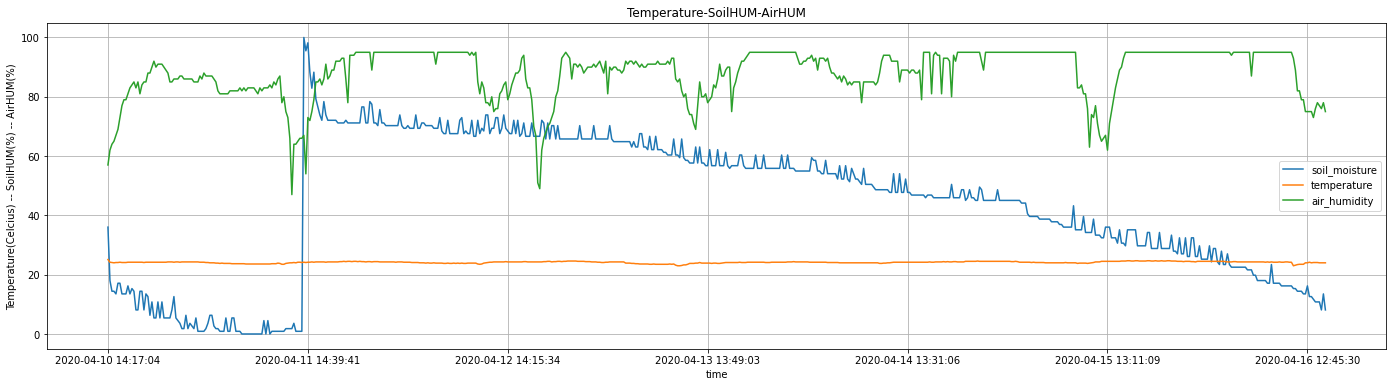

In [178]:
# register_matplotlib_converters()
plt.rcParams['figure.figsize'] = (24,6)   # Change the plot size
irrigation_data.plot(grid=True, title="Temperature-SoilHUM-AirHUM", kind="line").set_ylabel("Temperature(Celcius) -- SoilHUM(%) -- AirHUM(%)")




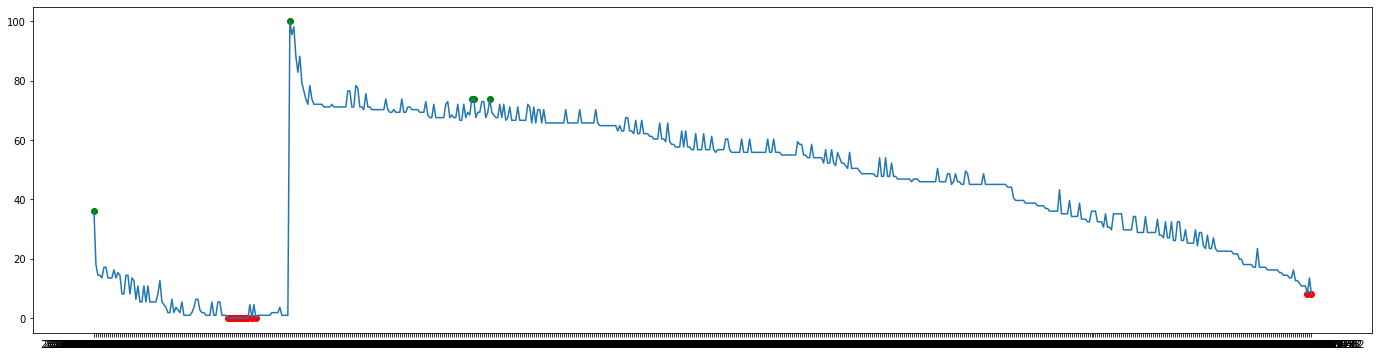

In [179]:
n=50 # number of points to be checked before and after 
# Find local peaks
irrigation_data['min'] = irrigation_data.iloc[argrelextrema(irrigation_data.soil_moisture.values, numpy.less_equal, order=n)[0]]['soil_moisture']
irrigation_data['max'] = irrigation_data.iloc[argrelextrema(irrigation_data.soil_moisture.values, numpy.greater_equal, order=n)[0]]['soil_moisture']

# Plot results
plt.scatter(irrigation_data.index, irrigation_data['min'], c='r')
plt.scatter(irrigation_data.index, irrigation_data['max'], c='g')
plt.plot(irrigation_data.index, irrigation_data['soil_moisture'])
plt.show()


In [180]:
threshold_value = irrigation_data.mean(axis = 0, skipna = True)[3]
print(f"Threshold Value: %{threshold_value}")
print(f"Min Moisture:{min_soil_moisture}")


Threshold Value: %1.0810810810810811
Min Moisture:0


In [181]:
irrigation_data["boolean"] = irrigation_data["min"]
for index, i in enumerate(irrigation_data["soil_moisture"]):
    if i < threshold_value:
        irrigation_data["boolean"][index] = 1
    else:
        irrigation_data["boolean"][index] = 0
    
irrigation_data["boolean"].fillna(0)
irrigation_data.drop(columns=['min', 'max'], inplace=True)
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(irrigation_data)

                     soil_moisture  temperature  air_humidity  boolean
time                                                                  
2020-04-10 14:17:04      36.036036         25.1          57.0      0.0
2020-04-10 14:31:04      18.018018         24.2          62.0      0.0
2020-04-10 14:45:09      14.414414         24.1          64.0      0.0
2020-04-10 14:59:14      14.414414         24.0          65.0      0.0
2020-04-10 15:13:23      13.513514         24.1          67.0      0.0
2020-04-10 15:27:31      17.117117         24.1          69.0      0.0
2020-04-10 15:41:39      17.117117         24.2          73.0      0.0
2020-04-10 15:56:00      13.513514         24.1          77.0      0.0
2020-04-10 16:10:30      13.513514         24.1          79.0      0.0
2020-04-10 16:24:55      13.513514         24.1          79.0      0.0
2020-04-10 16:39:11      16.216216         24.2          81.0      0.0
2020-04-10 16:53:18      13.513514         24.2          83.0      0.0
2020-0

In [182]:
irrigation_data.dropna(inplace=True)
irrigation_data.groupby('boolean').describe()
irrigation_data.describe()

,soil_moisture,temperature,air_humidity,boolean
count,610.000000,610.000000,610.000000,610.000000
mean,43.841382,24.158033,88.114754,0.059016
std,23.784833,0.301462,8.450374,0.235849
min,0.000000,23.000000,47.000000,0.000000
25%,25.225225,24.000000,84.000000,0.000000
50%,47.747748,24.200000,91.000000,0.000000
75%,65.765766,24.300000,95.000000,0.000000
max,100.000000,25.100000,95.000000,1.000000


In [183]:
irrigation_data_without_boolean = irrigation_data
irr_train, irr_test, label_train, label_test = train_test_split(irrigation_data,irrigation_data['boolean'],test_size=0.2)

irr_test



,soil_moisture,temperature,air_humidity,boolean
time,,,,
2020-04-13 02:02:48,65.765766,24.2,81.0,0.0
2020-04-14 17:44:53,45.945946,24.4,93.0,0.0
2020-04-16 11:19:48,15.315315,23.2,89.0,0.0
2020-04-15 18:35:54,28.828829,24.6,95.0,0.0
2020-04-16 08:44:24,17.117117,24.2,95.0,0.0
2020-04-12 01:37:22,73.873874,24.3,95.0,0.0
2020-04-11 09:46:46,0.900901,23.7,83.0,1.0
2020-04-13 15:13:55,56.756757,23.8,91.0,0.0
2020-04-10 19:49:50,5.405405,24.2,92.0,0.0


# MultinominalNB

In [184]:
pipeline = Pipeline([
    ('classifier',MultinomialNB()),
])

pipeline.fit(irr_train,label_train)
predictions = pipeline.predict(irr_test)
print(classification_report(predictions,label_test))


              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       104
         1.0       1.00      0.50      0.67        18

    accuracy                           0.93       122
   macro avg       0.96      0.75      0.81       122
weighted avg       0.93      0.93      0.92       122



# KNN

In [185]:
pipeline2 = Pipeline([
    ('classifier',KNeighborsClassifier(n_neighbors=3)),
])

pipeline2.fit(irr_train,label_train)
predictions = pipeline2.predict(irr_test)
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       112
         1.0       1.00      0.90      0.95        10

    accuracy                           0.99       122
   macro avg       1.00      0.95      0.97       122
weighted avg       0.99      0.99      0.99       122



# Logistic Regression

In [186]:
pipeline3 = Pipeline([
    ('classifier',LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')),
])

pipeline3.fit(irr_train,label_train)
predictions = pipeline3.predict(irr_test)
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       113
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



## GBRT

In [187]:
pipeline4 = Pipeline([
    ('classifier',GradientBoostingClassifier()),
])

pipeline4.fit(irr_train,label_train)
predictions = pipeline4.predict(irr_test)
print(classification_report(predictions,label_test))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       113
         1.0       1.00      1.00      1.00         9

    accuracy                           1.00       122
   macro avg       1.00      1.00      1.00       122
weighted avg       1.00      1.00      1.00       122



In [188]:
for i in predictions:
    print(i)

0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
